### Introduction:


The Marine Traffic Scraping Project is an iniative designed to explore real time web sccraping, data engineering, and analytics by capturing the ship data from [MarineTraffic.com](https://MarineTraffic.com). This would demonstrate a working real-time data pipeline that would store ship movements in a local SQLite database using Python.

I was able to access the data through browser developer tools, by fetching the ***Fetch/XHR*** requests in Chrome's Network Tab. By identifying the underlying JSON data endpoints, I was able to capture the data, including the dynamic attributes such as the position, speed, and destination, as well as the static metadata such as the ship dimensions and type

### Objective:

*   Learn and Apply real-time scraping techniques with headless browsers
*   Design and implement a lightweight data pipeline using SQLite
*   Showcase end to end data engineering, from extraction to storage and future visualizations
*   Enable spatial and temporal analysis on vessel movement data in specific geographic reigon

### Tools and Technology:

*   **Python** for scripting and async orchestration
*   **Playwright** for Javascript rendered scraping and is a bit more reliable then Selenium in handling dynamic web pages
*   **SQLite** and **DBeaver**
*   **aiosqlite** for asynchronous non-blocking inserts, improves the performance




In [50]:
import asyncio, argparse, base64, json, logging, re, random # for asynchronous tasks, argument parsing, encoding, JSON handling, logging, regular expressions, and randomness.
from datetime import datetime, timezone # Import datetime utilities to timestamp events in UTC (for consistency across global ship data)
from pathlib import Path  # Provides object-oriented path handling for file and directory operations.
from playwright.async_api import async_playwright #Asynchronous API, which would allow for automation for async event loop. Used to programmatically launch Chromium and interact with the MarineTraffic web interface.
DB_PATH = Path("ships.db") #For my previous usage of the script, I had focused on the Strait of Gibraltir

These are the libraries used for the analysis. Ideally the way I had thought it through was that the script would interact with the map to prevent the data stream from going idle while it parses through the data and stores it in a normalized SQLite database

In [51]:
def fnum(v):
    """Safely convert a value to a float.

    Returns the float value if conversion is successful, otherwise returns None.
    Useful for cleaning scraped numeric values that may be missing or malformed.
    """
    try: return float(v)
    except (ValueError, TypeError): return None

def inum(v):
    """Safely convert a value to an integer.

    Similar to fnum, but for integer values.
    Ensures downstream code doesn't break due to bad type casting.
    """
    try: return int(v)
    except (ValueError, TypeError): return None

def utc_now():
    """Get the current time in UTC as a formatted ISO 8601 string.

    This is used to timestamp each dynamic ship position so we can
    track movements over time in a consistent time zone.
    """
    return datetime.now(timezone.utc).isoformat()

The purpose of this part is to provide clean, fault-tolerant utility functions that would make sure that the scraper would not fail or even corrupt the data while processing the data.

*   `def fnum(v):` converts a scraped value into a float. Ship data (speed, latitude, longitutde) comes as strings, missing, malformed, or unexpected data. Tries to convert the data, if nothing, then this returns none
*   `def inum(v):`Same as the previous but for integer values in regards to elapsed or width. Ensures invalid values does not raise exceptions.
*   `def utc_now():`Provides the current UTC timestamp in ISO 8601 format. Used to timestamp each ships datapoint when storing in positions table.




In [52]:
# ---------- SQL Statements ----------
CREATE_STATIC = """
CREATE TABLE IF NOT EXISTS vessels(
  ship_id     TEXT PRIMARY KEY,
  shipname    TEXT,
  shiptype    TEXT,
  gt_shiptype TEXT,
  length      INTEGER,
  width       INTEGER,
  flag        TEXT
);
"""
CREATE_DYNAMIC = """
CREATE TABLE IF NOT EXISTS positions(
  id          INTEGER PRIMARY KEY AUTOINCREMENT,
  ship_id     TEXT,
  ts_utc      TEXT,
  lat         REAL,
  lon         REAL,
  speed       REAL,
  course      REAL,
  heading     REAL,
  elapsed     INTEGER,
  destination TEXT,
  l_form      TEXT,
  w_left      TEXT,
  dwt         TEXT,
  FOREIGN KEY(ship_id) REFERENCES vessels(ship_id)
);
"""
IDX = "CREATE INDEX IF NOT EXISTS idx_positions_ship_time ON positions(ship_id, ts_utc);"
UPSERT_STATIC = """
INSERT INTO vessels(ship_id, shipname, shiptype, gt_shiptype, length, width, flag)
VALUES (?,?,?,?,?,?,?)
ON CONFLICT(ship_id) DO UPDATE SET
  shipname    = excluded.shipname,
  shiptype    = excluded.shiptype,
  gt_shiptype = excluded.gt_shiptype,
  length      = excluded.length,
  width       = excluded.width,
  flag        = excluded.flag;
"""
INSERT_DYNAMIC = """
INSERT INTO positions(ship_id, ts_utc, lat, lon, speed, course, heading, elapsed,
                      destination, l_form, w_left, dwt)
VALUES (?,?,?,?,?,?,?,?,?,?,?,?);
"""


The purpose of using SQL was to store the data in a structured queryable format. I chose SQLite as it was simple, with zero setup, and the lightweight nature, making it deal for experiments and prototype.

The data is divided into two tables
*   `vessels`: for static metadata (ship name, type, flag)
*   `positions`: for dynamic telemtry (latitude, longitude, timestamp).

SQL would allow for:

*   Historical Tracking for ship positioning over time
*   Efficient Querying for the most recent data
*   Aggregation and Filtering for analytics and visualizations









In [53]:
# ---------- Database Wrappers ----------
class AsyncConnWrapper:
    """Wraps sync sqlite3 in async methods to keep the rest of the code consistent."""
    def __init__(self, conn):
        self.conn = conn
    async def execute(self, sql, params=()):
        return self.conn.execute(sql, params)
    async def executemany(self, sql, seq):
        return self.conn.executemany(sql, seq)
    async def commit(self):
        self.conn.commit()
    async def close(self):
        self.conn.close()

async def init_db(conn):
    """Initializes the database schema."""
    await conn.execute("PRAGMA journal_mode=WAL;")
    await conn.execute(CREATE_STATIC)
    await conn.execute(CREATE_DYNAMIC)
    await conn.execute(IDX)
    await conn.commit()

This section ensures that the database would be initialized, and that the code can work with synchronous (sqlite) and asynchronous (aiosqlite) database backends in a consistent way.

`class AsyncConnWrapper`

This wrapper class simulates the asynchronous behavior for sqlite3, which is note natively async. It would allow the rest of the codebase to use `await conn.execute(...)` regardless of whether aiosqlite is installed. This makes the pipeline more robust and modular.




In [54]:
async def writer_loop(queue, conn, last_write_time):
    """Consumes data from the queue and writes it to the database in batches."""
    last_pos_cache = {}
    while True:
        rows = await queue.get()
        if rows is None:
            break

        static_batch = []
        dynamic_batch = []
        now = utc_now()

        for r in rows:
            sid = r.get("SHIP_ID")
            if not sid: continue
#Would be the static data for the vessels table
            static_batch.append((
                sid, r.get("SHIPNAME"), r.get("SHIPTYPE"), r.get("GT_SHIPTYPE"),
                inum(r.get("LENGTH")), inum(r.get("WIDTH")), r.get("FLAG")
            ))
#Fills out position and movement data
            lat, lon = fnum(r.get("LAT")), fnum(r.get("LON"))
            speed, course = fnum(r.get("SPEED")), fnum(r.get("COURSE"))
#This would chekc for movement, it would skip if there isn't any
            key = (lat, lon, speed, course)
            if last_pos_cache.get(sid) == key:
                continue
            last_pos_cache[sid] = key
#Prepares dynamic row
            dynamic_batch.append((
                sid, now, lat, lon, speed, course, fnum(r.get("HEADING")),
                inum(r.get("ELAPSED")), r.get("DESTINATION"),
                r.get("L_FORM"), r.get("W_LEFT"), r.get("DWT")
            ))
# It would onyl write if there is a new Dynamic Data
        if dynamic_batch:
            try:
                await conn.execute("BEGIN")
                await conn.executemany(UPSERT_STATIC, static_batch)
                await conn.executemany(INSERT_DYNAMIC, dynamic_batch)
                await conn.commit()
                logging.info("Wrote %d new positions (from %d total vessels)", len(dynamic_batch), len(rows))
                # Update the shared timestamp to signal activity
                last_write_time[0] = asyncio.get_event_loop().time()
            except Exception as e:
                logging.error("Database write failed: %s", e)

        queue.task_done()


The `writer_loop` function is the core of the data ingestion pipeline, responsible for continuously consuming scraped ship data from an asynchronous queue and writing it into the SQLite database in structured batches. It separates each batch into two parts: static data (such as ship name, type, and dimensions) and dynamic data (like real-time position, speed, and destination). To reduce unnecessary database writes, it uses a caching mechanism (`last_pos_cache`) that skips entries if a ship’s location and movement have not changed since the last recorded state. Each batch of new data is written inside a transaction using `executemany()` for efficiency and atomicity, ensuring data integrity. A timestamp is also recorded after every successful write to monitor when the database was last updated. This loop ensures the database is kept up-to-date in real time with new and relevant data while avoiding duplicates and minimizing performance overhead.

In [55]:
# ---------- Main Scraper (Producer) ----------
async def run(args):
    """Main function to set up and run the scraper."""
    logging.basicConfig(level=getattr(logging, args.log.upper()),
                        format="%(asctime)s [%(levelname)s] %(message)s",
                        datefmt="%Y-%m-%d %H:%M:%S")

    if ASYNC_DB:
        conn = await dbmod.connect(DB_PATH.as_posix())
    else:
        logging.warning("aiosqlite not found, using standard sqlite3. Performance may be reduced.")
        conn_sync = dbmod.connect(DB_PATH.as_posix(), check_same_thread=False)
        conn = AsyncConnWrapper(conn_sync)

    await init_db(conn)

    queue = asyncio.Queue()
    last_write_time = [asyncio.get_event_loop().time()]
    writer = asyncio.create_task(writer_loop(queue, conn, last_write_time))

    url_pattern = re.compile(r"/getData/get_data_json_\d+/.*/station", re.I)

    consecutive_failures = 0

    # This outer loop manages the browser lifecycle, allowing for full restarts.
    while True:
        try:
            async with async_playwright() as p:
                browser = await p.chromium.launch(headless=args.headless == 1)
                ctx = await browser.new_context(user_agent="Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/98.0.4758.102 Safari/537.36")
                page = await ctx.new_page()

                async def handle_response(resp):
                    if url_pattern.search(resp.url):
                        try:
                            data = await resp.json()
                            rows = data.get("data", {}).get("rows", [])
                            if rows:
                                await queue.put(rows)
                                logging.debug("Captured %d rows from %s", len(rows), resp.url)
                        except Exception as e:
                            logging.warning("Failed to parse JSON from %s: %s", resp.url, e)

                ctx.on("response", handle_response)

                target_url = f"https://www.marinetraffic.com/en/ais/home/centerx:{args.centerx}/centery:{args.centery}/zoom:{args.zoom}"
                logging.info("Loading initial page: %s", target_url)
                await page.goto(target_url, wait_until="domcontentloaded", timeout=180000) # Increased timeout further
                await page.wait_for_selector("div.leaflet-container", timeout=90000) # Increased timeout further

                # If we successfully load the page, reset the failure counter.
                consecutive_failures = 0
                logging.info("Page loaded successfully.")

                for selector in ("button:has-text('AGREE')", "button:has-text('Accept')"):
                    try:
                        await page.locator(selector).click(timeout=15000) # Increased timeout further
                        logging.info("Dismissed a consent banner.")
                        break
                    except Exception:
                        pass

                logging.info("Scraper is running. Press Ctrl+C to stop.")
                end_time = None if args.duration == 0 else asyncio.get_event_loop().time() + args.duration * 60

                # --- Main Interaction Loop ---
                while end_time is None or asyncio.get_event_loop().time() < end_time:
                    now = asyncio.get_event_loop().time()

                    if now - last_write_time[0] > args.reload_timeout:
                        logging.warning("No data for %d seconds. Reloading page to refresh session.", args.reload_timeout)
                        try:
                            await page.reload(wait_until="domcontentloaded", timeout=180000) # Increased timeout further
                            await page.wait_for_selector("div.leaflet-container", timeout=90000) # Increased timeout further
                            last_write_time[0] = now
                            consecutive_failures = 0 # Success, reset counter
                        except Exception as e:
                            logging.error("Failed to reload page: %s.", e)
                            consecutive_failures += 1
                    else:
                        logging.info("Simulating map interaction to fetch new data...")
                        try:
                            viewport_size = page.viewport_size
                            if viewport_size:
                                center_x, center_y = viewport_size['width'] / 2, viewport_size['height'] / 2
                                await page.mouse.move(center_x, center_y)
                                await page.mouse.down()
                                await page.mouse.move(center_x + random.randint(-50, 50), center_y + random.randint(-50, 50), steps=10)
                                await page.mouse.up()
                            consecutive_failures = 0 # Success, reset counter
                        except Exception as e:
                            logging.warning("Could not simulate mouse drag: %s", e)
                            consecutive_failures += 1

                    # --- Circuit Breaker Logic ---
                    if consecutive_failures >= args.max_retries:
                        logging.critical("Exceeded max retries (%d). Restarting browser.", args.max_retries)
                        await browser.close() # Ensure current browser is closed
                        break # Exit inner loop to trigger outer loop restart

                    await asyncio.sleep(args.poll_interval)

                # If duration runs out, break the outer loop as well
                if end_time is not None and asyncio.get_event_loop().time() >= end_time:
                    break

        except Exception as e:
            logging.critical("A critical error occurred in the browser session: %s", e)
            consecutive_failures += 1
            if consecutive_failures >= args.max_retries:
                logging.critical("Exceeded max retries on critical error. Restarting browser.")
                # The loop will naturally restart, just wait a bit
                await asyncio.sleep(15)
            else:
                logging.warning("Retrying in %d seconds...", args.poll_interval)
                await asyncio.sleep(args.poll_interval)


    # --- Graceful Shutdown ---
    logging.info("Shutting down...")
    await queue.put(None)
    await writer
    await conn.close()
    logging.info("Shutdown complete.")

The core of this project revolves around an asynchronous web scraping pipeline. The scraper is designed using Python and Playwright to navigate MarineTraffic’s interactive map and capture real-time vessel data. It begins by establishing a connection to a local SQLite database, initializing the schema, and setting up a background task that writes incoming data in batches. Ship data is fetched by intercepting specific network responses triggered as the map loads new tiles. To continuously receive fresh data, the script simulates human-like mouse movements that cause the map to refresh, thereby prompting new vessel positions to load.

The scraper is resilient — it includes automatic reload mechanisms when data stops arriving, and it can fully restart the browser if necessary, ensuring long-term operation. All collected ship data is passed through an asynchronous queue into a writer process that efficiently logs it to disk, separating static (ship name, size) and dynamic (position, speed) details. With built-in logging and fault tolerance, this structure exemplifies a production-grade scraping system adaptable to unstable or interactive web environments.

In [56]:
# ---------- Command-Line Interface ----------
def parse_args():
    """Parses command-line arguments."""
    ap = argparse.ArgumentParser(description="MarineTraffic data scraper with auto-refresh.", formatter_class=argparse.ArgumentDefaultsHelpFormatter)
    ap.add_argument("--centerx", type=float, default=-74.0, help="Initial map center longitude.")
    ap.add_argument("--centery", type=float, default=40.7, help="Initial map center latitude.")
    ap.add_argument("--zoom", type=int, default=7, help="Initial map zoom level.")
    ap.add_argument("--duration", type=int, default=0, help="Run duration in minutes (0 = run forever).")
    ap.add_argument("--headless", type=int, default=1, choices=[0, 1], help="1 for headless, 0 for visible browser.")
    ap.add_argument("--log", default="INFO", choices=["DEBUG", "INFO", "WARNING", "ERROR"], help="Logging level.")
    ap.add_argument("--poll-interval", type=int, default=30, help="Seconds between map interactions.")
    ap.add_argument("--reload-timeout", type=int, default=90, help="Seconds of inactivity before reloading the page.")
    ap.add_argument("--max-retries", type=int, default=2, help="Max consecutive failures before restarting the browser.")
    # Use parse_known_args to ignore arguments passed by the Colab kernel
    args, unknown = ap.parse_known_args()
    return args

if __name__ == "__main__":
    try:
        # Use get_event_loop().run_until_complete() in Colab
        loop = asyncio.get_event_loop()
    except KeyboardInterrupt:
        logging.info("Keyboard interrupt received.")

To make the scraper user-friendly and configurable, I added a command-line interface using Python’s argparse module. This allows users to set the geographic region, zoom level, duration, browser visibility, logging verbosity, and error handling behavior directly from the terminal. For example, someone could easily scrape ships from Los Angeles at a higher zoom level for only 30 minutes with a visible browser by passing in appropriate flags. The script also includes a graceful shutdown mechanism, ensuring that even abrupt termination (e.g., pressing Ctrl+C) is handled cleanly and without data corruption.

**Step by Step Explanation of Scraper:**
1.   The script first sets up a logging system that prints timestamped messages at different severity levels (INFO, DEBUG, etc.). This helps track everything the script is doing while running.
2.  Depending on whether `aiosqlite` is available, it connects to the SQLite database in either async or sync mode. It then creates the necessary tables (`vessels` and `positions`) if they don't already exist.
3. An asynchronous queue is created to pass scraped data from the browser to the database writer. A separate task is started in the background to handle the writing of this data to the database (`writer_loop`).
4.A regular expression is defined to filter only those network responses from the MarineTraffic page that include ship data in a specific API format (`get_data_json`).
5.Using Playwright, the script launches a Chromium browser with a realistic user agent. This browser visits the MarineTraffic map at the location and zoom specified by the user.
6.The script listens for responses from the MarineTraffic website. When a response matches the expected data pattern, it parses the JSON and puts the rows of ship data into the queue
7.It tries to dismiss cookie banners or modal dialogs automatically so that data loading isn’t blocked by user prompts.
8.Since MarineTraffic only loads ships visible on the map, the script mimics human activity by randomly dragging the map slightly. This triggers new requests to load more vessel data tiles.
9.If the script detects that no new data has been written to the database for a certain number of seconds, it reloads the page to try and fix the issue
10.If page reloads fail several times in a row, the script closes the browser completely and restarts it to recover from possible memory leaks, session expiry, or unknown bugs.
11.When the user stops the script or the set time duration ends, it shuts down cleanly by signaling the writer loop to stop, waiting for all pending data to be written, and closing the database connection.





### Analysis

This section will be the analysis of the database after it has been scraped. For this example, I will be providing the ships I scraped only for the East Coast. Below will be some of the analysis I have done with the database. It is important that you understand the Standard AIS Ship Type Mapping. Below is a general mapping for commonly used codes:

* 20–29: Wing in ground (WIG)
* 30–39: Fishing
* 40–49: Tug, Pilot
* 50–59: Towing vessels
* 60–69: Passenger vessels
* 70–79: Cargo vessels
* 80–89: Tankers
* 90–99: Other ships
* 100–199: Special category
* 200–299: Reserved for regional use
* 300–399: Reserved for future use



In [175]:
import sqlite3
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import geopandas as gpd
from shapely.geometry import Point
import requests
import zipfile
import io
import os

conn = sqlite3.connect('/ships.db')

DB_PATH = "/ships.db"

conn = sqlite3.connect(DB_PATH)

tables = pd.read_sql_query("SELECT name FROM sqlite_master WHERE type='table';", conn)
print("Tables found:\n", tables)

positions_df = pd.read_sql_query("SELECT * FROM positions", conn)
vessels_df   = pd.read_sql_query("SELECT * FROM vessels",   conn)

positions_df.head(), vessels_df.head()

Tables found:
               name
0          vessels
1        positions
2  sqlite_sequence


(   id  ship_id                            ts_utc        lat        lon  speed  \
 0   1   690671  2025-07-23T19:59:12.951478+00:00  42.611374 -73.762054    0.0   
 1   2  6050749  2025-07-23T19:59:12.951478+00:00  40.928486 -73.905922    0.0   
 2   3   450645  2025-07-23T19:59:12.951478+00:00  41.064068 -73.128952  167.0   
 3   4  6496698  2025-07-23T19:59:12.951478+00:00  42.292652 -73.782448   98.0   
 4   5   443660  2025-07-23T19:59:12.951478+00:00  41.277874 -73.954872   61.0   
 
    course  heading  elapsed   destination l_form w_left    dwt  
 0   159.0      8.0        7         USALB   None     16  34094  
 1   127.0    187.0        5         USNYC   None     15   7735  
 2   338.0      NaN        5                 None      7    776  
 3   187.0    186.0        4        US SWF   None     12    512  
 4    37.0     35.0        5  US^0NFY>0LFQ   None     12    507  ,
    ship_id             shipname shiptype gt_shiptype  length  width flag
 0   690671              ORCINUS   

We inspect the structure of the SQLite database and load the positions and vessels tables into pandas DataFrames.

In [140]:
# Ensure ts_utc is datetime
positions_df["ts_utc"] = pd.to_datetime(positions_df["ts_utc"], errors="coerce")

# Derive date column (useful for grouping)
positions_df["date"] = positions_df["ts_utc"].dt.date

# Drop obvious bad lat/lon rows
positions_df["lat"] = pd.to_numeric(positions_df["lat"], errors="coerce")
positions_df["lon"] = pd.to_numeric(positions_df["lon"], errors="coerce")
valid_positions = positions_df.dropna(subset=["lat", "lon"])

# Merge on ship_id to get names/types attached to positions
merged_df = positions_df.merge(vessels_df, on="ship_id", how="left")

merged_df.head()

,id,ship_id,ts_utc,lat,lon,speed,course,heading,elapsed,destination,l_form,w_left,dwt,date,shipname,shiptype,gt_shiptype,length,width,flag
0,1,690671,2025-07-23 19:59:12.951478+00:00,42.611374,-73.762054,0.0,159.0,8.0,7,USALB,None,16,34094,2025-07-23,ORCINUS,7,6,178.0,28.0,LR
1,2,6050749,2025-07-23 19:59:12.951478+00:00,40.928486,-73.905922,0.0,127.0,187.0,5,USNYC,None,15,7735,2025-07-23,BALSA 96,7,9,106.0,19.0,PA
2,3,450645,2025-07-23 19:59:12.951478+00:00,41.064068,-73.128952,167.0,338.0,NaN,5,,None,7,776,2025-07-23,GRAND REPUBLIC,6,116,93.0,15.0,US
3,4,6496698,2025-07-23 19:59:12.951478+00:00,42.292652,-73.782448,98.0,187.0,186.0,4,US SWF,None,12,512,2025-07-23,JANICE ANN REINAUER,3,20,35.0,24.0,US
4,5,443660,2025-07-23 19:59:12.951478+00:00,41.277874,-73.954872,61.0,37.0,35.0,5,US^0NFY>0LFQ,None,12,507,2025-07-23,SAINT EMILION,3,54,33.0,11.0,US


This section ensures timestamps are in datetime format, latitude and longitude values are numeric, and merges both tables by `ship_id` for complete context.

In [161]:
def map_shiptype_category(code):
    if pd.isna(code):
        return "Unknown"
    code = int(code)
    if 20 <= code <= 29:
        return "WIG"
    elif 30 <= code <= 39:
        return "Fishing"
    elif 40 <= code <= 49:
        return "Tug/Pilot"
    elif 50 <= code <= 59:
        return "Towing Vessel"
    elif 60 <= code <= 69:
        return "Passenger"
    elif 70 <= code <= 79:
        return "Cargo"
    elif 80 <= code <= 89:
        return "Tanker"
    elif 90 <= code <= 99:
        return "Other"
    elif 100 <= code <= 199:
        return "Special Category"
    elif 200 <= code <= 299:
        return "Regional Use"
    elif 300 <= code <= 399:
        return "Reserved"
    else:
        return "Unknown"

# ✅ Apply it using gt_shiptype
merged_df['shiptype_category'] = merged_df['gt_shiptype'].apply(map_shiptype_category)

# ✅ Preview mapping
print(merged_df[['gt_shiptype', 'shiptype_category']].drop_duplicates().sort_values('gt_shiptype'))


     gt_shiptype shiptype_category
279          101  Special Category
1592         103  Special Category
1074         106  Special Category
9            109  Special Category
205           11           Unknown
313          111  Special Category
2            116  Special Category
1586         118  Special Category
823           12           Unknown
249          122  Special Category
209          127  Special Category
336          129  Special Category
1085          13           Unknown
1287         130  Special Category
6047         131  Special Category
270          132  Special Category
266          136  Special Category
1277         157  Special Category
253           16           Unknown
210           17           Unknown
241          171  Special Category
252           18           Unknown
281          189  Special Category
230           19           Unknown
262            2           Unknown
3             20               WIG
37            23               WIG
594           24    

We define and apply a mapping function based on AIS standard ship type code ranges.

Using `folium`, we plot ship positions on a map of the East Coast with popup details for sampled ships.

In [169]:
shiptype_mapping_preview = merged_df[['gt_shiptype', 'shiptype_category']].drop_duplicates().sort_values('gt_shiptype')
shiptype_mapping_preview



,gt_shiptype,shiptype_category
279,101,Special Category
1592,103,Special Category
1074,106,Special Category
9,109,Special Category
205,11,Unknown
313,111,Special Category
2,116,Special Category
1586,118,Special Category
823,12,Unknown
249,122,Special Category


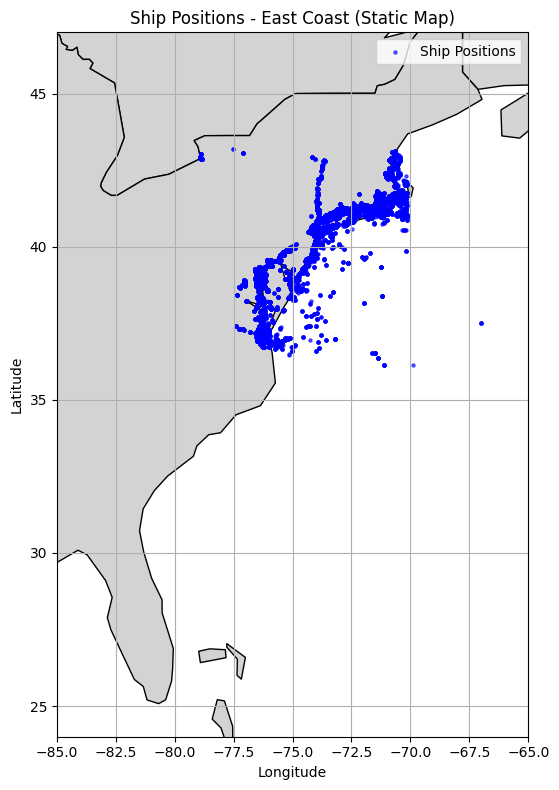

In [177]:
# Filter valid positions
geo_df = merged_df.dropna(subset=['lat', 'lon']).copy()
geo_df['geometry'] = geo_df.apply(lambda row: Point(row['lon'], row['lat']), axis=1)
geo_df = gpd.GeoDataFrame(geo_df, geometry='geometry', crs="EPSG:4326")

# Use Natural Earth data for base map (ensure correct URL)
url = "https://naturalearth.s3.amazonaws.com/110m_cultural/ne_110m_admin_0_countries.zip"
response = requests.get(url)
response.raise_for_status()

with zipfile.ZipFile(io.BytesIO(response.content)) as zf:
    zf.extractall("ne_110m_admin_0_countries")

world = gpd.read_file("ne_110m_admin_0_countries/ne_110m_admin_0_countries.shp")

# Plot static map
fig, ax = plt.subplots(figsize=(10, 8))
north_america = world[world['REGION_UN'] == 'Americas']  # or use 'SUBREGION' == 'Northern America' if available
north_america.plot(ax=ax, color='lightgray', edgecolor='black')
geo_df.plot(ax=ax, markersize=5, color='blue', alpha=0.6, label='Ship Positions')
ax.set_xlim([-85, -65])
ax.set_ylim([24, 47])
ax.set_title("Ship Positions - East Coast (Static Map)")
ax.set_xlabel("Longitude")
ax.set_ylabel("Latitude")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()